In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import st_simple as st
import model_confs as confs


import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_name = 'roberta'
model_conf = confs.roberta_conf
num_labels = 2

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,['about','to','as'],model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,['about','to','as'],model_conf) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskSimple(convai_train_token,task,eval=False)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskSimple(convai_val_token,task,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset(md_data,['about','to','as'],model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskSimple(md_tokenized,task,eval=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [14]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [15]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_about'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5804654987016206 	 Validation loss: 0.4004050659931312 	 
  1%|          | 574/57400 [01:35<2:27:31,  6.42it/s]
Epoch 2 	 Training loss: 0.40435758632857627 	 Validation loss: 0.35584874223854585 	 
  2%|▏         | 1148/57400 [03:09<2:30:21,  6.24it/s]
Epoch 3 	 Training loss: 0.36996274908764437 	 Validation loss: 0.3367525460356373 	 
  3%|▎         | 1722/57400 [04:44<2:23:35,  6.46it/s]
Epoch 4 	 Training loss: 0.35160056584699645 	 Validation loss: 0.3256099410986496 	 
  4%|▍         | 2296/57400 [06:19<2:23:01,  6.42it/s]
Epoch 5 	 Training loss: 0.33483959002361896 	 Validation loss: 0.3170499592009237 	 
  5%|▌         | 2870/57400 [07:54<2:21:24,  6.43it/s]
Epoch 6 	 Training loss: 0.3249048853377432 	 Validation loss: 0.31301443304045723 	 
  6%|▌         | 3444/57400 [09:29<2:15:00,  6.66it/s]
Epoch 7 	 Training loss: 0.316289728682631 	 Validation loss: 0.3096270020735466 	 
  7%|▋         | 4018/57400 [11:04<2:17:13,  6.48it/s]
Epoch 8 	 Traini

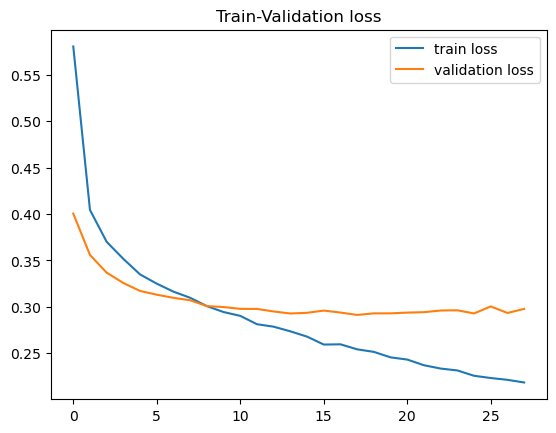

In [16]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [17]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8675, 'male': 0.8619791666666666, 'average': 0.8647395833333333}
precision {'female': 0.8675, 'male': 0.8619791666666666, 'average': 0.8647395833333333}
f1 {'female': 0.8675, 'male': 0.8619791666666666, 'average': 0.8647395833333333}
accuracy 0.8647959183673469


Evaluación en el conjunto el conjunto to
recall {'female': 0.7086614173228346, 'male': 0.7031630170316302, 'average': 0.7059122171772324}
precision {'female': 0.6887755102040817, 'male': 0.7225, 'average': 0.7056377551020409}
f1 {'female': 0.6985769728331177, 'male': 0.7127003699136868, 'average': 0.7056386713734022}
accuracy 0.7058080808080808


Evaluación en el conjunto el conjunto as
recall {'female': 0.6954177897574124, 'male': 0.696969696969697, 'average': 0.6961937433635548}
precision {'female': 0.6825396825396826, 'male': 0.7095115681233933, 'average': 0.696025625331538}
f1 {'female': 0.6889185580774365, 'male': 0.7031847133757961, 'average': 0.6960516357

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5589842526858692 	 Validation loss: 0.39547423033391016 	 
  1%|          | 574/57400 [01:32<2:25:28,  6.51it/s]
Epoch 2 	 Training loss: 0.39923093797645504 	 Validation loss: 0.3535934305292065 	 
  2%|▏         | 1148/57400 [03:05<2:22:06,  6.60it/s]
Epoch 3 	 Training loss: 0.3665474850801225 	 Validation loss: 0.34401196822271507 	 
  3%|▎         | 1722/57400 [04:38<2:21:08,  6.57it/s]
Epoch 4 	 Training loss: 0.34800164557292484 	 Validation loss: 0.32877613225225677 	 
  4%|▍         | 2296/57400 [06:12<2:21:33,  6.49it/s]
Epoch 5 	 Training loss: 0.33541171943269127 	 Validation loss: 0.31912392958746116 	 
  5%|▌         | 2870/57400 [07:45<2:21:27,  6.42it/s]
Epoch 6 	 Training loss: 0.32309598558767333 	 Validation loss: 0.31398175682051704 	 
  6%|▌         | 3444/57400 [09:19<2:21:48,  6.34it/s]
Epoch 7 	 Training loss: 0.3140698706387227 	 Validation loss: 0.30895654124728705 	 
  7%|▋         | 4018/57400 [10:52<2:18:04,  6.44it/s]
Epoch 8 	 T

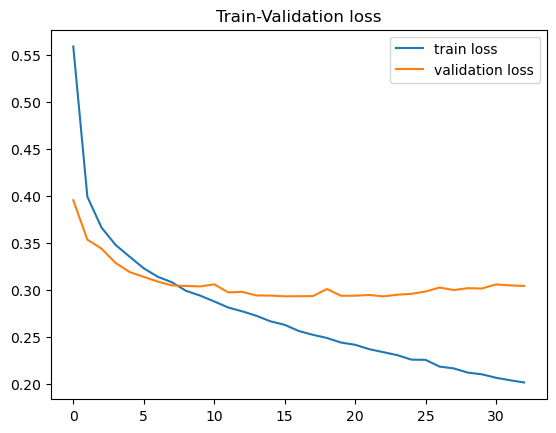

In [18]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [19]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8625, 'male': 0.8697916666666666, 'average': 0.8661458333333334}
precision {'female': 0.8734177215189873, 'male': 0.8586118251928021, 'average': 0.8660147733558947}
f1 {'female': 0.8679245283018868, 'male': 0.8641655886157826, 'average': 0.8660450584588347}
accuracy 0.8660714285714286


Evaluación en el conjunto el conjunto to
recall {'female': 0.6876640419947506, 'male': 0.7128953771289538, 'average': 0.7002797095618523}
precision {'female': 0.6894736842105263, 'male': 0.7111650485436893, 'average': 0.7003193663771079}
f1 {'female': 0.6885676741130091, 'male': 0.7120291616038881, 'average': 0.7002984178584486}
accuracy 0.7007575757575758


Evaluación en el conjunto el conjunto as
recall {'female': 0.6846361185983828, 'male': 0.7070707070707071, 'average': 0.6958534128345449}
precision {'female': 0.6864864864864865, 'male': 0.7052896725440806, 'average': 0.6958880795152835}
f1 {'female': 0.6855600539811066, 'male': 0.706

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5512892680197228 	 Validation loss: 0.3996785737700381 	 
  1%|          | 574/57400 [01:33<2:19:13,  6.80it/s]
Epoch 2 	 Training loss: 0.40574834010326905 	 Validation loss: 0.35835374462402475 	 
  2%|▏         | 1148/57400 [03:06<2:35:52,  6.01it/s]
Epoch 3 	 Training loss: 0.37038607223004827 	 Validation loss: 0.3375996242640382 	 
  3%|▎         | 1722/57400 [04:39<2:24:12,  6.44it/s]
Epoch 4 	 Training loss: 0.35061270346417245 	 Validation loss: 0.3293972646785995 	 
  4%|▍         | 2296/57400 [06:12<2:16:13,  6.74it/s]
Epoch 5 	 Training loss: 0.3399232034587694 	 Validation loss: 0.31893102218539027 	 
  5%|▌         | 2870/57400 [07:49<2:27:11,  6.17it/s]
Epoch 6 	 Training loss: 0.32738259203654135 	 Validation loss: 0.3125456649873216 	 
  6%|▌         | 3444/57400 [09:25<2:20:04,  6.42it/s]
Epoch 7 	 Training loss: 0.3169557468037572 	 Validation loss: 0.3078095935663934 	 
  7%|▋         | 4018/57400 [11:01<2:23:46,  6.19it/s]
Epoch 8 	 Train

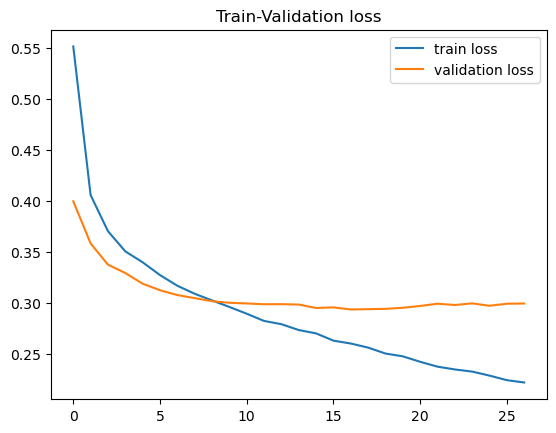

In [20]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [21]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8475, 'male': 0.8619791666666666, 'average': 0.8547395833333333}
precision {'female': 0.8647959183673469, 'male': 0.8443877551020408, 'average': 0.8545918367346939}
f1 {'female': 0.8560606060606061, 'male': 0.8530927835051546, 'average': 0.8545766947828803}
accuracy 0.8545918367346939


Evaluación en el conjunto el conjunto to
recall {'female': 0.6902887139107612, 'male': 0.7201946472019465, 'average': 0.7052416805563538}
precision {'female': 0.6957671957671958, 'male': 0.714975845410628, 'average': 0.705371520588912}
f1 {'female': 0.6930171277997366, 'male': 0.7175757575757575, 'average': 0.705296442687747}
accuracy 0.7058080808080808


Evaluación en el conjunto el conjunto as
recall {'female': 0.6873315363881402, 'male': 0.7196969696969697, 'average': 0.7035142530425549}
precision {'female': 0.6967213114754098, 'male': 0.7107231920199502, 'average': 0.70372225174768}
f1 {'female': 0.6919945725915875, 'male': 0.71518193

Resultados finales

In [22]:

print('f1 medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global F1:',mean(global_metrics[task]['f1']['average']))
    print(f'F1 etiqueta male:',mean(global_metrics[task]['f1']['male']))
    print('F1 etiqueta female: ',mean(global_metrics[task]['f1']['female']))

f1 medio de los 3 modelos: 


 about
Resultado global F1: 0.8617871121916828
F1 etiqueta male: 0.8597458462625346
F1 etiqueta female:  0.863828378120831

 to
Resultado global F1: 0.703744510639866
F1 etiqueta male: 0.7141017630311108
F1 etiqueta female:  0.6933872582486211

 as
Resultado global F1: 0.6985031495177756
F1 etiqueta male: 0.7081819041521743
F1 etiqueta female:  0.6888243948833769


In [23]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.8617871121916828
f1 etiqueta male: 0.8597458462625346
f1 etiqueta female:  0.863828378120831


TO
Resultado global f1: 0.703744510639866
f1 etiqueta male: 0.7141017630311108
f1 etiqueta female:  0.6933872582486211


AS
Resultado global f1: 0.6985031495177756
f1 etiqueta male: 0.7081819041521743
f1 etiqueta female:  0.6888243948833769


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.8617871121916828
recall etiqueta male: 0.8597458462625346
recall etiqueta female:  0.863828378120831


TO
Resultado global recall: 0.703744510639866
recall etiqueta male: 0.7141017630311108
recall etiqueta female:  0.6933872582486211


AS
Resultado global recall: 0.6985031495177756
recall etiqueta male: 0.7081819041521743
recall etiqueta female:  0.6888243948833769


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.8617871121916828
precision etiqueta male: 0.8597458462625346
precision etiqueta female:  0.86382

# TO

In [24]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933746410579216 	 Validation loss: 0.6925331788547968 	 
  1%|          | 574/57400 [01:33<2:31:53,  6.24it/s]
Epoch 2 	 Training loss: 0.6933779779834615 	 Validation loss: 0.6931548744945203 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:06<2:27:58,  6.34it/s]
Epoch 3 	 Training loss: 0.6933076017201986 	 Validation loss: 0.6920590451208212 	 
  3%|▎         | 1722/57400 [04:39<2:19:07,  6.67it/s]
Epoch 4 	 Training loss: 0.6934228989097715 	 Validation loss: 0.693137321431758 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:13<2:23:55,  6.38it/s]
Epoch 5 	 Training loss: 0.6933921704308912 	 Validation loss: 0.6927166439719119 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [07:45<2:18:52,  6.54it/s]
Epoch 6 	 Training loss: 0.6931863210134805 	 Validation loss: 0.6922370306516098 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [09:18<2:22:03,  6.33it/s]
Epoch 7 	 Training loss: 0.6932355084485708 	 

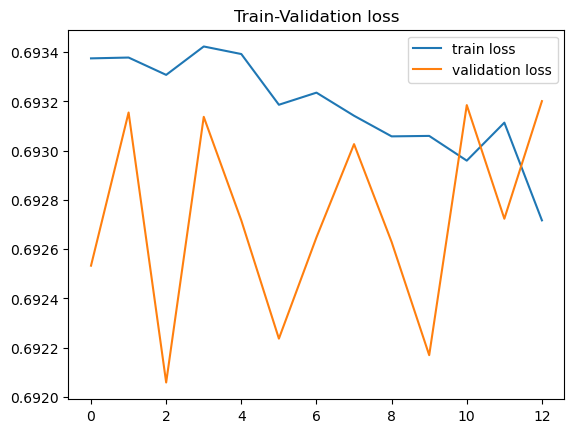

In [25]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [26]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about


c:\Users\FarinhOso\anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall {'female': 1.0, 'male': 0.0, 'average': 0.5}
precision {'female': 0.5102040816326531, 'male': 0.0, 'average': 0.25510204081632654}
f1 {'female': 0.6756756756756758, 'male': 0.0, 'average': 0.3378378378378379}
accuracy 0.5102040816326531


Evaluación en el conjunto el conjunto to


c:\Users\FarinhOso\anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall {'female': 1.0, 'male': 0.0, 'average': 0.5}
precision {'female': 0.4810606060606061, 'male': 0.0, 'average': 0.24053030303030304}
f1 {'female': 0.6496163682864451, 'male': 0.0, 'average': 0.32480818414322254}
accuracy 0.4810606060606061


Evaluación en el conjunto el conjunto as
recall {'female': 1.0, 'male': 0.0, 'average': 0.5}
precision {'female': 0.48370273794002605, 'male': 0.0, 'average': 0.24185136897001303}
f1 {'female': 0.6520210896309314, 'male': 0.0, 'average': 0.3260105448154657}
accuracy 0.48370273794002605


c:\Users\FarinhOso\anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.697236557040065 	 Validation loss: 0.6936433466814332 	 
  1%|          | 574/57400 [01:33<2:27:27,  6.42it/s]
Epoch 2 	 Training loss: 0.6958012038822373 	 Validation loss: 0.6923378776695769 	 
  2%|▏         | 1148/57400 [03:06<2:12:58,  7.05it/s]
Epoch 3 	 Training loss: 0.6955102935485308 	 Validation loss: 0.6932120282771224 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:39<2:20:57,  6.58it/s]
Epoch 4 	 Training loss: 0.6949639554015435 	 Validation loss: 0.6926483491719779 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [06:12<2:21:41,  6.48it/s]
Epoch 5 	 Training loss: 0.6950144008684657 	 Validation loss: 0.6926106497392817 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [07:44<2:15:52,  6.69it/s]
Epoch 6 	 Training loss: 0.6951885351112911 	 Validation loss: 0.6925529170844514 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [09:17<2:20:39,  6.39it/s]
Epoch 7 	 Training loss: 0.6949764105916438 	 

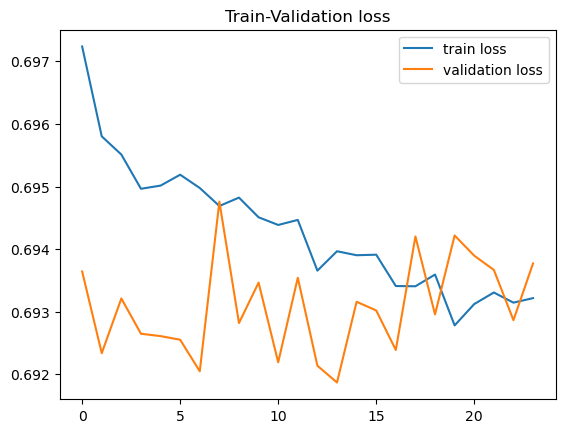

In [27]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_to2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [28]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.9175, 'male': 0.14583333333333334, 'average': 0.5316666666666666}
precision {'female': 0.5280575539568345, 'male': 0.6292134831460674, 'average': 0.5786355185514509}
f1 {'female': 0.6703196347031963, 'male': 0.23678646934460887, 'average': 0.4535530520239026}
accuracy 0.5395408163265306


Evaluación en el conjunto el conjunto to
recall {'female': 0.94750656167979, 'male': 0.17274939172749393, 'average': 0.560127976703642}
precision {'female': 0.514978601997147, 'male': 0.7802197802197802, 'average': 0.6475991911084635}
f1 {'female': 0.66728280961183, 'male': 0.2828685258964143, 'average': 0.47507566775412213}
accuracy 0.5454545454545454


Evaluación en el conjunto el conjunto as
recall {'female': 0.9272237196765498, 'male': 0.16414141414141414, 'average': 0.545682566908982}
precision {'female': 0.5096296296296297, 'male': 0.7065217391304348, 'average': 0.6080756843800322}
f1 {'female': 0.6577437858508604, 'male': 0.26639

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.7032101987130966 	 Validation loss: 0.6930475628982156 	 
  1%|          | 574/57400 [01:33<2:25:34,  6.51it/s]
Epoch 2 	 Training loss: 0.6981480373945801 	 Validation loss: 0.6923302664595136 	 
  2%|▏         | 1148/57400 [03:07<2:25:26,  6.45it/s]
Epoch 3 	 Training loss: 0.6959659122839207 	 Validation loss: 0.6927825242786084 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:40<2:19:53,  6.63it/s]
Epoch 4 	 Training loss: 0.6952309740337346 	 Validation loss: 0.6926781696788336 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [06:13<2:24:05,  6.37it/s]
Epoch 5 	 Training loss: 0.6947926080393043 	 Validation loss: 0.6928335822234719 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [07:46<2:20:13,  6.48it/s]
Epoch 6 	 Training loss: 0.6946511970579832 	 Validation loss: 0.6920065324185258 	 
  6%|▌         | 3444/57400 [09:20<2:20:50,  6.38it/s]
Epoch 7 	 Training loss: 0.6946543086488903 	 Validation loss: 0.692494364

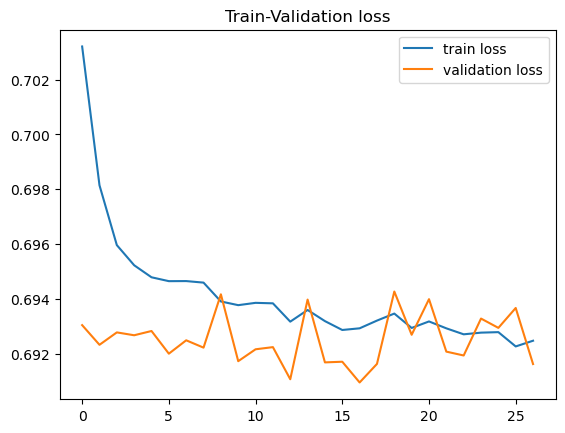

In [29]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_to3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [30]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.965, 'male': 0.11458333333333333, 'average': 0.5397916666666667}
precision {'female': 0.5316804407713499, 'male': 0.7586206896551724, 'average': 0.6451505652132612}
f1 {'female': 0.6856127886323269, 'male': 0.19909502262443438, 'average': 0.4423539056283806}
accuracy 0.548469387755102


Evaluación en el conjunto el conjunto to
recall {'female': 0.952755905511811, 'male': 0.145985401459854, 'average': 0.5493706534858325}
precision {'female': 0.5084033613445378, 'male': 0.7692307692307693, 'average': 0.6388170652876535}
f1 {'female': 0.6630136986301369, 'male': 0.24539877300613497, 'average': 0.45420623581813596}
accuracy 0.5340909090909091


Evaluación en el conjunto el conjunto as
recall {'female': 0.9568733153638814, 'male': 0.14393939393939395, 'average': 0.5504063546516377}
precision {'female': 0.5115273775216138, 'male': 0.7808219178082192, 'average': 0.6461746476649165}
f1 {'female': 0.6666666666666667, 'male': 0.24

Resultados finales

In [31]:

for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.4112482651633737
f1 etiqueta male: 0.14529383065634774
f1 etiqueta female:  0.6772026996703997


TO
Resultado global f1: 0.41803002923849353
f1 etiqueta male: 0.1760890996341831
f1 etiqueta female:  0.659970958842804


AS
Resultado global f1: 0.4143158912074595
f1 etiqueta male: 0.1698212683654328
f1 etiqueta female:  0.6588105140494862


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.4112482651633737
recall etiqueta male: 0.14529383065634774
recall etiqueta female:  0.6772026996703997


TO
Resultado global recall: 0.41803002923849353
recall etiqueta male: 0.1760890996341831
recall etiqueta female:  0.659970958842804


AS
Resultado global recall: 0.4143158912074595
recall etiqueta male: 0.1698212683654328
recall etiqueta female:  0.6588105140494862


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.4112482651633737
precision etiqueta male: 0.14529383065634774
precision etiqueta female:  

# AS

In [32]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6976082341596225 	 Validation loss: 0.6925169795246447 	 
  1%|          | 574/57400 [01:33<2:22:31,  6.65it/s]
Epoch 2 	 Training loss: 0.696596090075031 	 Validation loss: 0.6927300267300364 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:06<2:28:50,  6.30it/s]
Epoch 3 	 Training loss: 0.696769648001169 	 Validation loss: 0.6915198231147508 	 
  3%|▎         | 1722/57400 [04:40<2:21:01,  6.58it/s]
Epoch 4 	 Training loss: 0.6963113496527854 	 Validation loss: 0.6920097399566133 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:14<2:23:01,  6.42it/s]
Epoch 5 	 Training loss: 0.695937630399179 	 Validation loss: 0.6940161181708514 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [07:46<2:23:10,  6.35it/s]
Epoch 6 	 Training loss: 0.6958215088171411 	 Validation loss: 0.6933791920290155 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [09:20<2:02:50,  7.32it/s]
Epoch 7 	 Training loss: 0.6951883156955865 	 Va

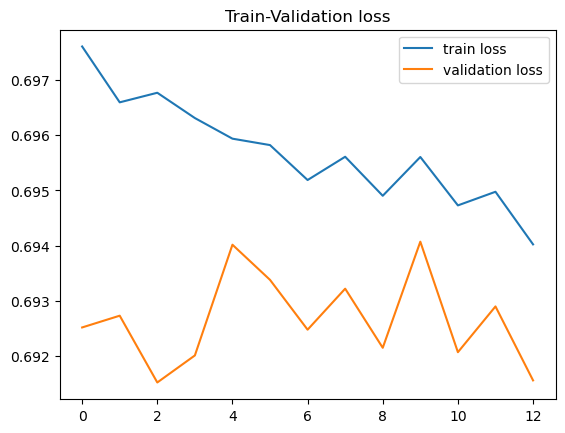

In [33]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_as'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [34]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about


c:\Users\FarinhOso\anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall {'female': 1.0, 'male': 0.0, 'average': 0.5}
precision {'female': 0.5102040816326531, 'male': 0.0, 'average': 0.25510204081632654}
f1 {'female': 0.6756756756756758, 'male': 0.0, 'average': 0.3378378378378379}
accuracy 0.5102040816326531


Evaluación en el conjunto el conjunto to
recall {'female': 1.0, 'male': 0.004866180048661801, 'average': 0.5024330900243309}
precision {'female': 0.48227848101265824, 'male': 1.0, 'average': 0.7411392405063291}
f1 {'female': 0.6507258753202392, 'male': 0.009685230024213076, 'average': 0.3302055526722261}
accuracy 0.48358585858585856


Evaluación en el conjunto el conjunto as
recall {'female': 1.0, 'male': 0.0025252525252525255, 'average': 0.5012626262626263}
precision {'female': 0.48433420365535246, 'male': 1.0, 'average': 0.7421671018276762}
f1 {'female': 0.6525945470536499, 'male': 0.005037783375314861, 'average': 0.3288161652144824}
accuracy 0.485006518904824


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934363396533275 	 Validation loss: 0.6936235043962123 	 
  1%|          | 574/57400 [01:33<2:27:31,  6.42it/s]
Epoch 2 	 Training loss: 0.6935312110372537 	 Validation loss: 0.6929305791854858 	 
  2%|▏         | 1148/57400 [03:07<2:24:01,  6.51it/s]
Epoch 3 	 Training loss: 0.6932797349911534 	 Validation loss: 0.6920020893468695 	 
  3%|▎         | 1722/57400 [04:41<2:31:15,  6.13it/s]
Epoch 4 	 Training loss: 0.6933421489461373 	 Validation loss: 0.6940557249521805 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:14<2:26:10,  6.28it/s]
Epoch 5 	 Training loss: 0.693163118711332 	 Validation loss: 0.6936028650251486 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [07:47<2:22:50,  6.36it/s]
Epoch 6 	 Training loss: 0.6932655571852827 	 Validation loss: 0.6924511992325217 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [09:20<2:19:42,  6.44it/s]
Epoch 7 	 Training loss: 0.6931400906541206 	 Validation loss: 0.6930038009

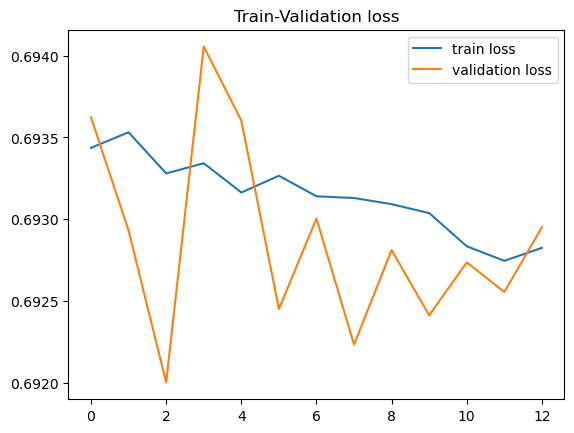

In [35]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_as2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [36]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about


c:\Users\FarinhOso\anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall {'female': 1.0, 'male': 0.0, 'average': 0.5}
precision {'female': 0.5102040816326531, 'male': 0.0, 'average': 0.25510204081632654}
f1 {'female': 0.6756756756756758, 'male': 0.0, 'average': 0.3378378378378379}
accuracy 0.5102040816326531


Evaluación en el conjunto el conjunto to


c:\Users\FarinhOso\anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall {'female': 1.0, 'male': 0.0, 'average': 0.5}
precision {'female': 0.4810606060606061, 'male': 0.0, 'average': 0.24053030303030304}
f1 {'female': 0.6496163682864451, 'male': 0.0, 'average': 0.32480818414322254}
accuracy 0.4810606060606061


Evaluación en el conjunto el conjunto as
recall {'female': 1.0, 'male': 0.0, 'average': 0.5}
precision {'female': 0.48370273794002605, 'male': 0.0, 'average': 0.24185136897001303}
f1 {'female': 0.6520210896309314, 'male': 0.0, 'average': 0.3260105448154657}
accuracy 0.48370273794002605


c:\Users\FarinhOso\anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6949732556991045 	 Validation loss: 0.6914121771262864 	 
  1%|          | 574/57400 [01:34<2:29:30,  6.33it/s]
Epoch 2 	 Training loss: 0.6945917152569269 	 Validation loss: 0.6934834152965222 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:07<2:27:32,  6.35it/s]
Epoch 3 	 Training loss: 0.6946106748298485 	 Validation loss: 0.6930672192977647 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [04:40<2:20:43,  6.59it/s]
Epoch 4 	 Training loss: 0.6947386397717307 	 Validation loss: 0.693214200310788 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [06:13<2:18:33,  6.63it/s]
Epoch 5 	 Training loss: 0.6943358391627202 	 Validation loss: 0.6931935659909653 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [07:46<2:18:06,  6.58it/s]
Epoch 6 	 Training loss: 0.6941086803579164 	 Validation loss: 0.6921385860039015 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [09:19<2:19:17,  6.46it/s]
Epoch 7 	 Trainin

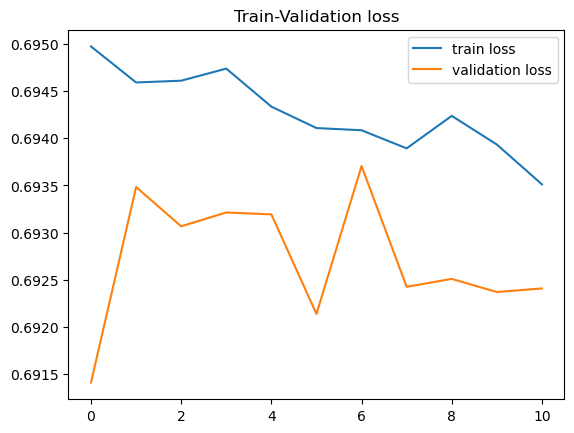

In [37]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
save_path=f'simple_{model_name}_as3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [38]:
model = st.SingleTaskSimple(model_conf,num_labels=num_labels).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.9975, 'male': 0.0, 'average': 0.49875}
precision {'female': 0.5095785440613027, 'male': 0.0, 'average': 0.2547892720306513}
f1 {'female': 0.6745562130177516, 'male': 0.0, 'average': 0.3372781065088758}
accuracy 0.5089285714285714


Evaluación en el conjunto el conjunto to
recall {'female': 0.994750656167979, 'male': 0.0024330900243309003, 'average': 0.49859187309615494}
precision {'female': 0.4803548795944233, 'male': 0.3333333333333333, 'average': 0.4068441064638783}
f1 {'female': 0.6478632478632478, 'male': 0.004830917874396136, 'average': 0.32634708286882197}
accuracy 0.4797979797979798


Evaluación en el conjunto el conjunto as
recall {'female': 1.0, 'male': 0.0025252525252525255, 'average': 0.5012626262626263}
precision {'female': 0.48433420365535246, 'male': 1.0, 'average': 0.7421671018276762}
f1 {'female': 0.6525945470536499, 'male': 0.005037783375314861, 'average': 0.3288161652144824}
accuracy 0.485006518904824


Resultados finales

In [39]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.33765126072818386
f1 etiqueta male: 0.0
f1 etiqueta female:  0.6753025214563677


TO
Resultado global f1: 0.32712027322809023
f1 etiqueta male: 0.00483871596620307
f1 etiqueta female:  0.6494018304899773


AS
Resultado global f1: 0.3278809584148102
f1 etiqueta male: 0.0033585222502099076
f1 etiqueta female:  0.6524033945794104


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.33765126072818386
recall etiqueta male: 0.0
recall etiqueta female:  0.6753025214563677


TO
Resultado global recall: 0.32712027322809023
recall etiqueta male: 0.00483871596620307
recall etiqueta female:  0.6494018304899773


AS
Resultado global recall: 0.3278809584148102
recall etiqueta male: 0.0033585222502099076
recall etiqueta female:  0.6524033945794104


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.33765126072818386
precision etiqueta male: 0.0
precision etiqueta female:  0.6753025214563677


TO
Resultado g